# Práctica Transfer Learning 2 

## 1. Carga de librerías

In [46]:
# General
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Keras
import keras
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from keras.utils import image_dataset_from_directory

In [47]:
tam_imagen = 224
ruta_imagenes = "/kaggle/input/ejemplo-imagenes-comidas/ejemplos_imagenes_comidas"

tamaño de imagenes y la ruta al dataset de pruebas

In [48]:
modelo1 = Sequential([
    MobileNetV2(input_shape=(tam_imagen, tam_imagen, 3), weights='imagenet')
])

for nombre_archivo in os.listdir(ruta_imagenes):
    ruta_imagen = os.path.join(ruta_imagenes, nombre_archivo)
    if ruta_imagen.endswith(('.jpg','.png','.jpeg')):
        imagen = Image.open(ruta_imagen).resize((tam_imagen, tam_imagen))
        imagen = np.array(imagen) / 255
        resultado = modelo1.predict(imagen[np.newaxis, ...])
        codigo = np.argmax(resultado[0])
        fichero_etiquetas = keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
        etiquetas = np.array(open(fichero_etiquetas).read().splitlines())
        print(nombre_archivo, ":", etiquetas[codigo])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
imagen_prueba_nachos.jpg : menu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
imagen_prueba_guacamole.jpg : plate
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
imagen_prueba_donut.jpg : French loaf


Carga del modelo de MobileNetV2, y predicción sobre el dataset de pruebas

In [49]:
batch_size = 32
carpeta_train = '/kaggle/input/dataset-imagenes-comidas-full/dataset_imagenes_comidas/imagenes_comidas/train'
carpeta_test = '/kaggle/input/dataset-imagenes-comidas-full/dataset_imagenes_comidas/imagenes_comidas/test'
clases = ['donuts', 'guacamole', 'nachos']
# Preprocesamiento de imágenes de entrada
train_dataset = image_dataset_from_directory(
 carpeta_train,
 image_size=(tam_imagen, tam_imagen),
 batch_size=batch_size,
 labels='inferred',
 #label_mode='categorical',
 class_names=clases
)
test_dataset = image_dataset_from_directory(
 carpeta_test,
 image_size=(tam_imagen, tam_imagen),
 batch_size=batch_size,
 labels='inferred',
 #label_mode='categorical',
 class_names=clases
)

Found 2400 files belonging to 3 classes.
Found 600 files belonging to 3 classes.


División de train y test sobre el dataset más cargado de imagenes

In [50]:
# Etapas de aumento de datos y escalado
data_augmentation = Sequential([
 RandomFlip("horizontal"),
 RandomRotation(0.2),
 RandomZoom(0.1),
 RandomTranslation(0.1, 0.1)
])

In [51]:
normalizacion = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y:(data_augmentation(normalizacion(x)), y))
test_dataset = test_dataset.map(lambda x, y: (normalizacion(x), y))

In [52]:
# Construcción del modelo
extractor = MobileNetV2(input_shape=(tam_imagen, tam_imagen, 3), include_top=False, weights='imagenet')
extractor.trainable = False
modelo2 = Sequential([
 extractor,
 GlobalAveragePooling2D(),
 Dense(128, activation='relu'),
 # Crearemos una red para identificar 3 tipos de comida
 Dense(3, activation='softmax')
])

Definición de la arquitectura simple aplicada al modelo preentrenado

In [54]:
modelo2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelo2.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 525ms/step - accuracy: 0.7939 - loss: 0.4877 - val_accuracy: 0.9117 - val_loss: 0.2533
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 471ms/step - accuracy: 0.8792 - loss: 0.3095 - val_accuracy: 0.9067 - val_loss: 0.2344
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 466ms/step - accuracy: 0.9065 - loss: 0.2465 - val_accuracy: 0.9300 - val_loss: 0.1892
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 481ms/step - accuracy: 0.9129 - loss: 0.2227 - val_accuracy: 0.9050 - val_loss: 0.2137
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 472ms/step - accuracy: 0.9240 - loss: 0.2018 - val_accuracy: 0.9250 - val_loss: 0.2146


Entrenamiento del modelo

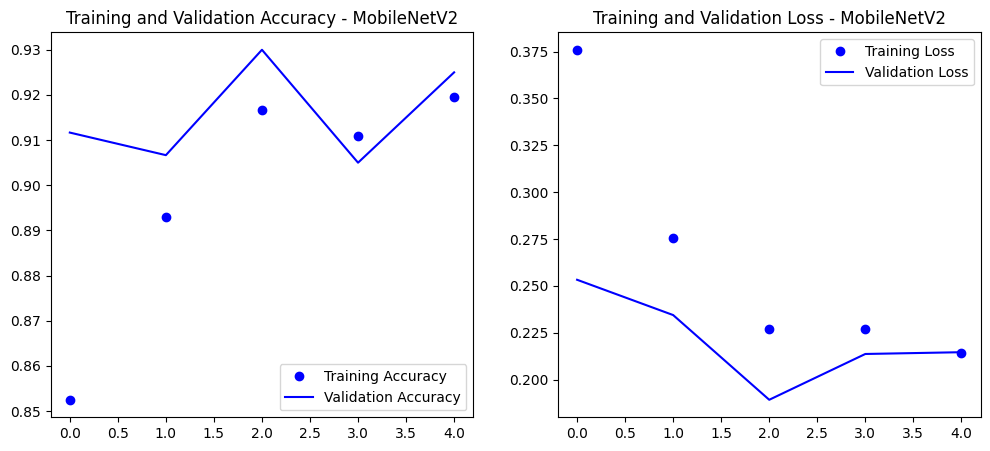

In [55]:
accuracy = modelo2.history.history['accuracy']
val_accuracy = modelo2.history.history['val_accuracy']
loss = modelo2.history.history['loss']
val_loss = modelo2.history.history['val_loss']
epochs = range(len(accuracy))

plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy - MobileNetV2')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title(f'Training and Validation Loss - MobileNetV2')
plt.legend()

plt.show()

Visualización de métricas

In [56]:
# Obtener predicciones del modelo
predictions = modelo2.predict(test_dataset)  # Obtiene probabilidades para cada clase
predicted_labels = np.argmax(predictions, axis=1)  # Convierte a etiquetas de clase

# Obtener las etiquetas verdaderas del dataset de prueba
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)  # Extraer etiquetas verdaderas
true_labels = np.argmax(true_labels, axis=1)  # Convertir one-hot a índices de clase

# Definir nombres de clases
num_classes = 3
target_names = [f"Class {i}" for i in range(num_classes)]

# Generar el informe de clasificación
print(f'Classification Report - MobileNetV2')
print(classification_report(true_labels, predicted_labels, target_names=target_names))

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step
Classification Report - MobileNetV2
              precision    recall  f1-score   support

     Class 0       0.34      0.33      0.34       200
     Class 1       0.29      0.29      0.29       200
     Class 2       0.39      0.41      0.40       200

    accuracy                           0.34       600
   macro avg       0.34      0.34      0.34       600
weighted avg       0.34      0.34      0.34       600



Reporte de clasificación

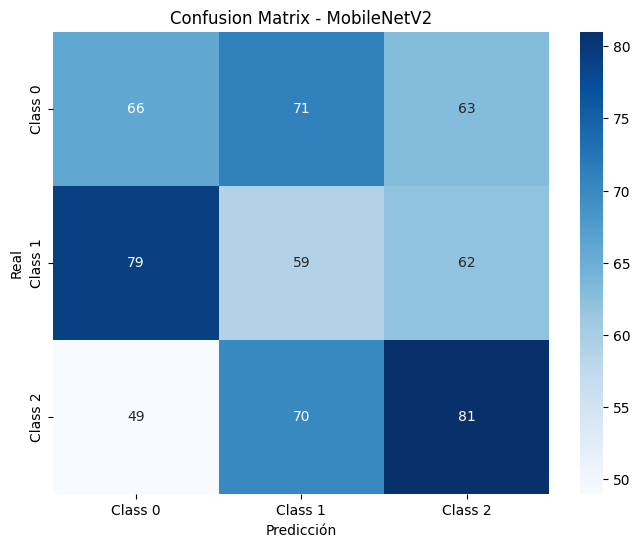

In [57]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
labels = [f"Class {i}" for i in range(num_classes)]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix - MobileNetV2')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Matriz de confusión

In [58]:
for nombre_archivo in os.listdir(ruta_imagenes):
    ruta_imagen = os.path.join(ruta_imagenes, nombre_archivo)
    if ruta_imagen.endswith(('.jpg','.png','.jpeg')):
        imagen = Image.open(ruta_imagen).resize((tam_imagen, tam_imagen))
        imagen = np.array(imagen) / 255
        resultado = modelo2.predict(imagen[np.newaxis, ...])
        codigo = np.argmax(resultado[0])
        fichero_etiquetas = keras.utils.get_file('ImageNetLabels.txt', 
                                                 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
        etiquetas = np.array(open(fichero_etiquetas).read().splitlines())
        print(nombre_archivo, ":", etiquetas[codigo])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
imagen_prueba_nachos.jpg : goldfish
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
imagen_prueba_guacamole.jpg : tench
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
imagen_prueba_donut.jpg : background


Prueba del dataset de prueba con el modelo2

In [62]:
for nombre_archivo in os.listdir(ruta_imagenes):
    ruta_imagen = os.path.join(ruta_imagenes, nombre_archivo)
    
    if ruta_imagen.endswith(('.jpg', '.png', '.jpeg')):
        imagen = Image.open(ruta_imagen).resize((tam_imagen, tam_imagen))
        imagen = np.array(imagen) / 255.0
        imagen = np.expand_dims(imagen, axis=0)  # Agregar dimensión batch

        resultado = modelo2.predict(imagen)  # Usar modelo entrenado en comidas
        codigo = np.argmax(resultado[0])  # Obtener clase predicha

        etiquetas = np.array(clases)  # Usar las clases correctas
        print(nombre_archivo, ":", etiquetas[codigo])  # Mostrar resultado


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
imagen_prueba_nachos.jpg : nachos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
imagen_prueba_guacamole.jpg : guacamole
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
imagen_prueba_donut.jpg : donuts


¿Por qué antes no ha funcionado y ahora si? Porque se estaba prediciendo sobre el .txt con las 1000 clases del dataset, hay que predecirlo del entrenamiento custom